In [100]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries
import scqubits as scq
from modeling.resonance_fit import ResFit

In [101]:
df = pd.DataFrame(columns=['qb0','qb1'])

### Direct coupling between qubits
We create a network consisting of the two qubits without coupler, capacitively coupled only trhough the spurious crosstalk component. We retrieve the coupling strength by inspecting the avoided crossing.

In [102]:
# Crosstalk matrix
# 1 - Lower pad of qb1
# 2 - Upper pad of qb1
# 3 - Lower pad of qb2
# 4 - Upper pad of qb2
C11 = 1.06053733201e-13
C12 = 3.66861355889e-14
C13 = 2.18187498008e-17
C14 = 1.39279875929e-17
C22 = 1.08514488394e-13
C23 = 3.29784355009e-17
C24 = 2.09781223949e-17
C33 = 1.07015490075e-13
C34 = 3.67196762469e-14
C44 = 1.08496195805e-13

cir = Network([
    C(0, 1, C11),
    C(1, 2, C12),
    C(1, 3, C13),
    C(1, 4, C14),
    C(2, 3, C23),
    C(2, 0, C22),
    C(2, 4, C24),
    C(0, 3, C33),
    C(3, 4, C34),
    C(0, 4, C44),

    J(1, 2, 'Lj1'),
    J(3, 4, 'Lj2'),
    ])
Lj1_list = np.linspace(10.03e-9,10.0307e-9,201)
freqs = cir.eigenfrequencies(Lj1=Lj1_list, Lj2 = 10e-9)
g_12 = abs(freqs[0] - freqs[1]).min()/2
df.loc['spurious crosstalk (shared) [kHz]/2pi'] = [g_12/1e3, g_12/1e3]
print(f"Crosstalk coupling strength: {g_12/1e3 :.2f} kHz")

Crosstalk coupling strength: 29.19 kHz


### Target parameters 
We set design parameters (CPW traces, permittivity...) and target parameters (frequencies, coupling)

In [103]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.226e9, 6.958e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array(6.7e9)
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma = 90e-15
chi = 0.072499e6
kappa_target = 1e6
qubit_freq_target = [4.354e9, 3.938e9]

g_coupling_target = 90e6

### Optimization function
We build the effective circuit and quantize it using QuCAT, tuning the coupling capacitances and Ljs to match the coupling strength targets.

Qubit and resonators are modeled as grounded LC resonators.

In [104]:
def get_g(EC, Ej, c_coupling, c_r, wr):
    # From Manenti and Motta book
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_r) * np.sqrt(2*planck_h * wr * (c_r))
    return g

def minimize_func(x, c_rr = None, l_rr = None, c_cr = None, l_cr = None, qubit_freq_target = None, 
                  g_coupling_target = None, chi = None):
    c_r1 = abs(x[0]*1e-15)
    c_r2 = abs(x[1]*1e-15)
    c_c1 = abs(x[2]*1e-15)
    c_c2 = abs(x[3]*1e-15)
    Lj1 = x[4]*1e-9
    Lj2 = x[5]*1e-9

    EC = e_charge**2/(c_sigma)/2/planck_h
    Ic1 = get_Ic_from_Lj(Lj1)
    Ej1 = Ic1*phi0/2/pi/planck_h
    Ic2 = get_Ic_from_Lj(Lj2)
    Ej2 = Ic2*phi0/2/pi/planck_h

    cir = Network([
        C(0,1, c_sigma - c_r1 - c_c1), # transmon 1
        J(0,1, Lj1),
        C(0,2, c_sigma - c_r2 - c_c2), # transmon 2
        J(0,2,Lj2),

        C(0,3, c_rr[0] - c_r1), # readout resonator 1
        L(0,3, l_rr[0]),
        C(0,4, c_rr[1] - c_r2), # readout resonator 2
        L(0,4, l_rr[1]),
        C(0, 5, c_cr - c_c1 - c_c2), # coupling resonator 
        L(0, 5, l_cr),

        C(1, 3, c_r1), # transmon 1 - readout resonator 1
        C(2, 4, c_r2), # transmon 2 - readout resonator 2
        C(1, 5, c_c1), # transmon 1 - coupling resonator
        C(2, 5, c_c2), # transmon 2 - coupling resonator
    ])
    chi1 = cir.kerr()[1, 4]/2
    chi2 = cir.kerr()[0, 3]/2
    g1_c = get_g(EC, Ej1, c_c1, c_cr, cplr_freq_target)
    g2_c = get_g(EC, Ej2, c_c2, c_cr, cplr_freq_target)
    
    H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
    eigs = H.eigenenergies().real
    eigs -= eigs[0]
    freq_qb_1 = eigs[2]
    freq_qb_2 = eigs[1]

    err_chi1 = abs((chi1 - chi) / 1e6)
    err_chi2 = abs((chi2 - chi) / 1e6)
    err_g1 = abs((g1_c - g_coupling_target) / 1e9)
    err_g2 = abs((g2_c - g_coupling_target) / 1e9)
    err_freq1 = abs((freq_qb_1 - qubit_freq_target[0]) / 1e9)
    err_freq2 = abs((freq_qb_2 - qubit_freq_target[1]) / 1e9)
    return err_chi1, err_chi2, err_g1, err_g2, err_freq1, err_freq2


In [105]:
minimize_func([3, 3, 2, 2, 14, 15], c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi)

(0.05592468570946432,
 0.053015311121764636,
 0.05648113446319348,
 0.057054317753502636,
 0.09670517130587149,
 0.1669535448364868)

In [106]:
# Bounds can be set when using the least square solver instead of fsolve. They don't seem to be necessary now.
lower_bounds = [0, 0, 0, 0, 10, 11]
upper_bounds = [6, 6, 9, 9, 16, 17]
solution = fsolve(minimize_func, [3, 3, 3, 3, 14, 15], args =(c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi))

In [107]:
# solution = np.array([ 3.37558607,  3.3106131 ,  4.82574001,  4.87440512, 11.24867581,
#        11.70933423])

In [108]:
c_r1, c_r2, c_c1, c_c2, Lj1, Lj2 = abs(solution)*np.array([1e-15, 1e-15, 1e-15, 1e-15, 1e-9, 1e-9])

In [109]:
c_r1, c_r2, c_c1, c_c2, Lj1, Lj2

(2.145922667764778e-15,
 2.3823779584499426e-15,
 5.312475082023934e-15,
 5.5710772720410674e-15,
 1.3408582995166695e-08,
 1.6216308187850318e-08)

In [110]:
minimize_func(solution, c_rr, l_rr, c_cr, l_cr, qubit_freq_target, g_coupling_target, chi)

(8.258502930402756e-12,
 6.022615707479417e-12,
 2.9802322387695314e-17,
 2.3080408573150635e-13,
 1.3742446899414063e-12,
 3.3473968505859376e-13)

In [111]:
EC = e_charge**2/(c_sigma)/2/planck_h
Ic1 = get_Ic_from_Lj(Lj1)
Ej1 = Ic1*phi0/2/pi/planck_h
Ic2 = get_Ic_from_Lj(Lj2)
Ej2 = Ic2*phi0/2/pi/planck_h
g_r1 = get_g(EC, Ej1, c_r1, c_rr[0], rr_freq_target[0])
g_r2 = get_g(EC, Ej2, c_r2, c_rr[1], rr_freq_target[1])

cir = Network([
    C(0,1, c_sigma - c_r1 - c_c1), # transmon 1
    J(0,1, Lj1),
    C(0,2, c_sigma - c_r2 - c_c2), # transmon 2
    J(0,2, Lj2),

    C(0,3, c_rr[0] - c_r1), # readout resonator 1
    L(0,3, l_rr[0]),
    C(0,4, c_rr[1] - c_r2), # readout resonator 2
    L(0,4, l_rr[1]),
    C(0, 5, c_cr - c_c1 - c_c2), # coupling resonator 
    L(0, 5, l_cr),

    C(1, 3, c_r1), # transmon 1 - readout resonator 1
    C(2, 4, c_r2), # transmon 2 - readout resonator 2
    C(1, 5, c_c1), # transmon 1 - coupling resonator
    C(2, 5, c_c2), # transmon 2 - coupling resonator
])
tmon1 = scq.Transmon(EC=EC, EJ = Ej1, ncut = 31, ng = 0)
anharm1 = tmon1.anharmonicity()
tmon2 = scq.Transmon(EC=EC, EJ = Ej2, ncut = 31, ng = 0)
anharm2 = tmon2.anharmonicity()

df.loc['Ic [nA]'] = [Ic1/1e-9, Ic2/1e9]
df.loc['Anharmonicity [MHz]/2pi'] = [anharm1/1e6, anharm2/1e6]
df.loc['chi [kHz]/2pi'] = [cir.kerr()[1, 4]/1e3, cir.kerr()[0, 3]/1e3]


In [112]:
c_c1

5.312475082023934e-15

In [113]:
_ = cir.f_k_A_chi(pretty_print=True) # note that qubit modes correspond to the linear inductance approximation.

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.16 GHz |          0Hz |      214 MHz |
            1 |     4.58 GHz |          0Hz |      214 MHz |
            2 |     6.71 GHz |          0Hz |     2.13 kHz |
            3 |     6.96 GHz |          0Hz |      24.5 Hz |
            4 |     7.23 GHz |          0Hz |      24.5 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |         2    |         3    |         4    |
            0 |      214 MHz |              |              |              |              |
            1 |     17.4 kHz |      214 MHz |              |              |              |
            2 |      812 kHz |     1.08 MHz |     2.13 kHz |              |              |
            3 |      145 kHz |       123 Hz |       275 Hz |      24.5 Hz |              |
            4 |      20.7 Hz |      145 kHz |       366 Hz |     46.6 mHz |      24.5 Hz |



In [114]:
H = cir.hamiltonian(modes = [0, 1, 2, 3, 4],
                    taylor = 7,
                    excitations = [6, 6, 2, 2, 2])
eigs = H.eigenenergies()
eigs -= eigs[0]
df.loc['Qubit frequency [GHz]/2pi'] = [eigs[2].real/1e9, eigs[1].real/1e9]
df.loc['Coupler frequency (shared) [GHz]/2pi'] = [eigs[3].real/1e9, eigs[3].real/1e9]
df.loc['rr frequency [GHz]/2pi'] = [eigs[5].real/1e9, eigs[4].real/1e9]

In [115]:
expected_g1 = get_g(EC, Ej1, c_r1, c_rr[0], rr_freq_target[0]) * 2 * pi
expected_g2 = get_g(EC, Ej2, c_r2, c_rr[1], rr_freq_target[1]) * 2 * pi
delta1 = 2*pi*abs(eigs[5] - eigs[2])
delta2 = 2*pi*abs(eigs[4] - eigs[1])

lamb_shift1 = 2*expected_g1**2 / delta1 / 2 / np.pi
lamb_shift2 = 2*expected_g2**2 / delta1 / 2 / np.pi
print(f"Expected Lamb shift for qb1: {lamb_shift1/1e6 :.4} MHz")
print(f"Expected Lamb shift for qb2: {lamb_shift2/1e6 :.4} MHz")

df.loc['Qubit-rr coupling strength [MHz]/2pi'] = [expected_g1/1e6/2/np.pi, expected_g2/1e6/2/np.pi]
df.loc['rr Lamb shift [MHz]/2pi'] = [lamb_shift1/1e6, lamb_shift2/1e6]

Expected Lamb shift for qb1: 1.07 MHz
Expected Lamb shift for qb2: 1.112 MHz


We extract the resonator-feedline capacitances based on the desired kappa.

In [116]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi #/ np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((2))
for i in range(2):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15

df.loc['rr-feedline capacitance [fF]'] = [cks[0]/1e-15, cks[1]/1e-15]
df.loc['rr FWHM linewidth (kappa) [MHz]/2pi'] = [resonator_kappa(rr_freq_target[0], cks[0], Z0) / 2 / pi / np.sqrt(2) / 1e6, 
                               resonator_kappa(rr_freq_target[1], cks[1], Z0) / 2 / pi / np.sqrt(2) / 1e6]

In [117]:
qb1_lib = clockmon_coupling_libraries(port_id = "0_2")
qb2_lib = clockmon_coupling_libraries(port_id = "0_3")
ck_given_coupling = get_ck()

qb1_coupler_widths = qb1_lib(c_r1, c_c1)
qb2_coupler_widths = qb2_lib(c_r2, c_c2)
finger_control = ck_given_coupling(cks)

print(f"Coupler 0 width for qubit 1: {qb1_coupler_widths[0]:.5} um")
print(f"Coupler 2 width for qubit 1: {qb1_coupler_widths[1]:.5} um")
print(f"Coupler 0 width for qubit 2: {qb2_coupler_widths[0]:.5} um")
print(f"Coupler 3 width for qubit 2: {qb1_coupler_widths[1]:.5} um")
print(f"Finger control for qubit 1: {finger_control[0]:.5}")
print(f"Finger control for qubit 2: {finger_control[1]:.5}")

Coupler 0 width for qubit 1: nan um
Coupler 2 width for qubit 1: nan um
Coupler 0 width for qubit 2: 52.379 um
Coupler 3 width for qubit 2: nan um
Finger control for qubit 1: 2.1759
Finger control for qubit 2: 2.2226


# Waveguide length estimation
Here we estimate the waveguide length to be set in "dimensioned chip", by taking into account the coupling loads and the added capacitance and inductance to ground given by couplers.

In [118]:
cr1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 0)
cc1_to_ground = clockmon_cqr_to_ground(port_id = "0_2", ground_id = 1)

cr2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 0)
cc2_to_ground = clockmon_cqr_to_ground(port_id = "0_3", ground_id = 1)
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])

In [119]:
# Readout resonators (lambda/4)
rr_cap_to_ground = np.array([cr1_to_ground((c_r1, c_c1)), cr2_to_ground((c_r2, c_c2))])
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 4
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - rr_cap_to_ground - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= [c_r1, c_r2]
c_r_loaded -= cks
rr_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for rr1: {rr_waveguide_lengths[0]*1e6 : 2f} um")
print(f"Waveguide length for rr2: {rr_waveguide_lengths[1]*1e6 : 2f} um")

Waveguide length for rr1:  nan um
Waveguide length for rr2:  4077.050381 um


In [120]:
cr1_to_ground((c_r1*1.4, c_c1/2))

array(8.93329764e-15)

In [121]:
c_r1, c_c1

(2.145922667764778e-15, 5.312475082023934e-15)

In [122]:
c_r2, c_c2

(2.3823779584499426e-15, 5.5710772720410674e-15)

In [123]:
# Coupler (lambda/2)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_length = v_ph / cplr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_length*c_l - cc1_to_ground((c_r1, c_c1)) - cc2_to_ground((c_r1, c_c2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_length*c_l - cc1_to_ground((c_r1, c_c1)) - cc2_to_ground((c_r1, c_c2)))*
                                (unloaded_wg_length*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= (c_c1 + c_c2)
cplr_waveguide_length = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
print(f"Waveguide length for coupler: {cplr_waveguide_length*1e6 : 2f} um")

Waveguide length for coupler:  nan um


### Build the scikit-rf model

In [124]:
fl_traits = pd.read_csv("two_clockmons_00.csv").values[0][1:]
transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)/2*1e6]
options = {
    "qubit_c": np.array([c_sigma]*2) - np.array([c_r1, c_r2]) - np.array([c_c1, c_c2]) ,
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_rr - np.array([c_r1, c_r2]) - cks,
    "readout_resonator_l": l_rr,
    "substrate_thickness": 550e-6,
    "ck": cks,
    "cqr": np.array([c_r1, c_r2]),
    "cc": np.array([c_c1, c_c2]),
    "coupler_res_c": c_cr - c_c1 - c_c2,
    "coupler_res_l": l_cr,
    "feedline_traits": transmission_line_tee_points,
    "ep_r": ep_r,
    "a": a,
    "b": b,
    "frequency": [7.2, 7.21],
    "n_points": 201,
    "type": "two_coupled"
}

2-Port Network: '',  7.2-7.21 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


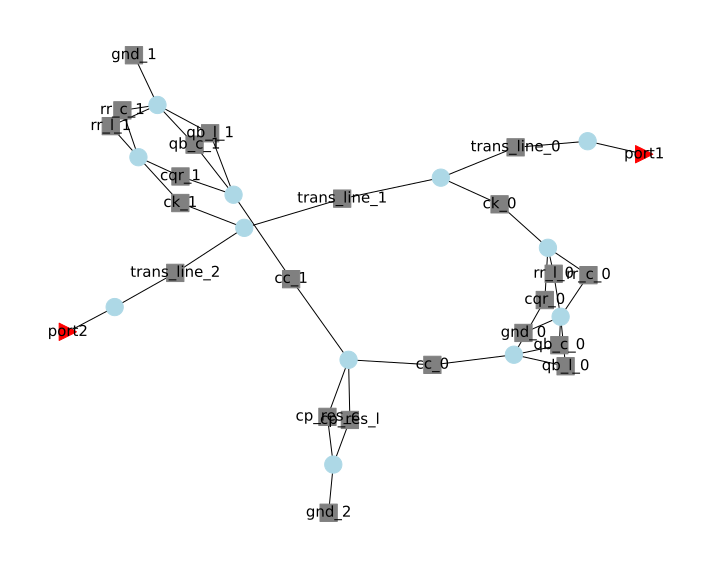

In [125]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

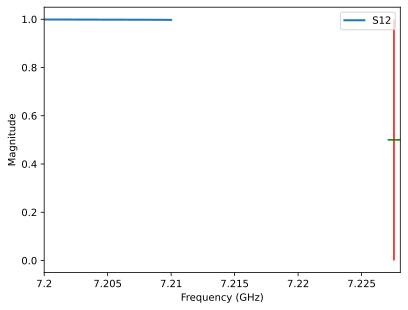

In [126]:
ntw.plot_s_mag(m=0, n=1, lw=2)
correction1 = 480e3 # A correction is needed for two reasons:
# The qubit here is linear, hence the frequency detuning is about 10% different from the transmon-like case.
# The qubit-qubit coupler adds another shift.
plt.vlines(x = rr_freq_target[0] + correction1 + lamb_shift1, ymin = 0, ymax = 1, colors="red")
plt.hlines(y = 0.5, xmin =  rr_freq_target[0] + correction1 + lamb_shift1 - kappa_target/2, xmax = rr_freq_target[0] + lamb_shift1 + correction1+ kappa_target/2, colors="green")

In [127]:
# initial_params = [1, 1e3, 6, 2, 0, 0, 0]
# fitter = ResFit(ntw, 0, 1400, ideal = True)
# fitter.fit_resonance(initial_params=initial_params)
# fitter.plot_resonance()

In [128]:
# kappa = (fitter.popt[0] + fitter.fmin) / fitter.popt[1]
# kappa

### Purcell limit and driveline coupling
Q extracted from Im(Y)/Re(Y)

https://arxiv.org/pdf/2101.09532

https://doi.org/10.1063/1.5089550

https://arxiv.org/abs/2106.06173

In [129]:
Q_dl_q1 = 1.5e6 #5051296.014504992 #9kk vs 15 kk

P_in = -66 # on-driveline power
V0 = 10**(P_in/20) * np.sqrt(Z0/1000)

omega_q1 = qubit_freq_target[0]*2*np.pi
Gamma_q1 = omega_q1 / Q_dl_q1
c_dl_q1 = np.sqrt(Gamma_q1*c_sigma/Z0)/omega_q1
Omega_q1 = V0*c_dl_q1/c_sigma * np.sqrt(planck_h/4/np.pi / Z0) / planck_h
pi_pulse_time_q1 = (1 / (Omega_q1/2/np.pi) )/ 4
T1_purcell_q1 = 1/Gamma_q1 * 1e6
print(f"driveline-qubit capacitance: {c_dl_q1/1e-15:.4f} fF")
print(f"pi-pulse duration: {pi_pulse_time_q1*1e9:.2f} ns")
print(f"T1 purcell from driveline qb1: {T1_purcell_q1} us")
c_dl_q1

driveline-qubit capacitance: 0.2076 fF
pi-pulse duration: 3.92 ns
T1 purcell from driveline qb1: 54.83059592049679 us


2.0757402993820986e-16

In [130]:
0.206 - 0.281

-0.07500000000000004

In [131]:
c22 = 149.89 - 37
c33 = 149.89 - 37
c12 = 0.0112
c13 = 0.0087
# (C12*C33 - C13*C22) / (C22 + C12 + C33 + C13)
(c12 * c22 - c13*c22) / (c22 + c12 + c33 + c13)

0.001249889836089388

In [132]:
Q_dl_q2 = 6118963.2619058965
P_in = -66 # on-driveline power
V0 = 10**(P_in/20) * np.sqrt(Z0/1000)

w_q2 = qubit_freq_target[1]*2*np.pi
Gamma_q2 = w_q2 / Q_dl_q2
c_dl_q2 = np.sqrt(Gamma_q2*c_sigma)/w_q2/Z0
Omega_q2 = V0*c_dl_q2/c_sigma * np.sqrt(planck_h/4/np.pi / Z0) / planck_h
pi_pulse_time_q2 = (1 / (Omega_q2/2/np.pi) )/ 4
T1_purcell_q2 = 1/Gamma_q2 * 1e6

print(f"driveline-qubit capacitance: {c_dl_q2/1e-15:.4f} fF")
print(f"pi-pulse duration: {pi_pulse_time_q2*1e9:.2f} ns")
print(f"T1 purcell from driveline qb2: {T1_purcell_q2} us")

driveline-qubit capacitance: 0.0151 fF
pi-pulse duration: 53.74 ns
T1 purcell from driveline qb2: 247.2989460970115 us


In [133]:
resonator_kappa(rr_freq_target, cks, Z0)

array([6283185.30717959, 6283185.30717959])

In [136]:
g_r2

39969030.24648128

In [137]:
expected_g1 = 40e6*np.pi*2

In [138]:
# Readout resonator Purcell
delta = (rr_freq_target - qubit_freq_target)*2*np.pi
k_purcell = 38021857* (expected_g1/delta)**2
gamma_hz = 38021857 * (expected_g1 / (6.958e9 - 3.938e9)/2/np.pi)**2 * 2*np.pi
T1_purcell_rr = 1/gamma_hz
print(T1_purcell_rr)
print(f"T1 purcell from readout resonator qb1: {T1_purcell_rr[0]*1e6} us")
print(f"T1 purcell from readout resonator qb2: {T1_purcell_rr[1]*1e6} us")

2.3860564315929552e-05


TypeError: 'float' object is not subscriptable

In [ ]:
kappa_target

1000000.0

In [ ]:
19529729.72972973
38021857.92349727

38021857.92349727

In [ ]:
expected_g1

419554699.6984043

### scikit-rf model for T1
We can compute T1 Purcell by replacing qubits with ports and calculating the admittance. This will also account for T1 Purcell through the coupler.

1-Port Network: '',  4.0-5.0 GHz, 201 pts, z0=[50.+0.j]


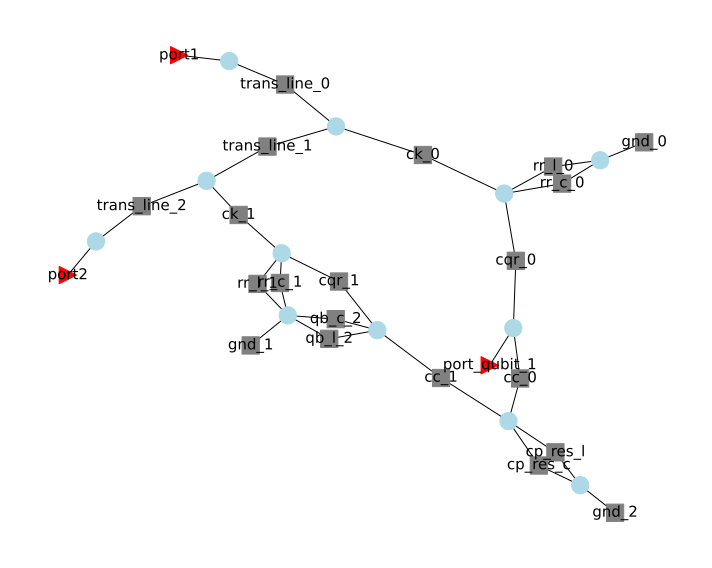

In [ ]:
options = {
    "qubit_c": np.array([c_sigma]*2) - np.array([c_r1, c_r2]) - np.array([c_c1, c_c2]) ,
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_rr - np.array([c_r1, c_r2]) - cks,
    "readout_resonator_l": l_rr,
    "ck": cks,
    "substrate_thickness": 550e-6,
    "cqr": np.array([c_r1, c_r2]),
    "cc": np.array([c_c1, c_c2]),
    "qubit_to_estimate": 0,
    "coupler_res_c": (c_cr - c_c1 - c_c2)*1e-10,
    "coupler_res_l": l_cr*1e-10,
    "feedline_traits": transmission_line_tee_points,
    "ep_r": ep_r,
    "a": a,
    "b": b,
    "frequency": [4, 5],
    "n_points": 201,
    "type": "T1_Purcell_estimation_coupled_qubits"
}
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

In [ ]:
transmission_line_tee_points

[377.20799999999997, 2477.208, 657.2080000000001]

In [ ]:
transmission_line_tee_points

[377.20799999999997, 2477.208, 657.2080000000001]

In [ ]:
freq_span_s1 = np.linspace(options["frequency"][0], options["frequency"][1], options["n_points"])
qb_idx = np.argmin(abs(freq_span_s1 - qubit_freq_target[0]/1e9))
Y_real_s1 = ntw.y[qb_idx, 0, 0].real
T1_s1_readout_purcell_limit = c_sigma/Y_real_s1
print(f"T1_s1_readout_purcell_limit: {T1_s1_readout_purcell_limit*1e6} us")

T1_s1_readout_purcell_limit: 801.2432694705686 us


In [ ]:
60*16

960

In [ ]:
T1_purcell_q2

247.2989460970115

In [ ]:
df["T1 purcell from driveline [us]"] = [T1_purcell_q1, T1_purcell_q2]
df["T1 purcell from rr [us]"] = [T1_purcell_rr[0]*1e6, T1_purcell_rr[1]*1e6]

ValueError: Length of values (2) does not match length of index (11)

In [ ]:
J = g_coupling_target**2*(tmon1.E01() + tmon2.E01() - 2*cplr_freq_target) / (2*(tmon1.E01() - cplr_freq_target) * (tmon2.E01() - cplr_freq_target))
print(f"Exchange rate J: {J/1e6:.4f} MHz / 2pi")
df["Exchange rate (shared) [MHz]/2pi"] = [J/1e6, J/1e6]

Exchange rate J: -3.1936 MHz / 2pi


ValueError: Length of values (2) does not match length of index (11)

In [ ]:
# From QDAST\src\modeling\clockmon\dielectric_losses.ipynb
# df.loc["T1 TLS [us]"] = [77.289792, 79.010464]
print(df)

                                              qb0           qb1
spurious crosstalk (shared) [kHz]/2pi   29.188891  2.918889e+01
Ic [nA]                                 24.549382  2.029882e-17
Anharmonicity [MHz]/2pi               -244.686828 -2.488902e+02
chi [kHz]/2pi                          420.000000  4.200000e+02
Qubit frequency [GHz]/2pi                4.354000  3.938000e+00
Coupler frequency (shared) [GHz]/2pi     6.712942  6.712942e+00
rr frequency [GHz]/2pi                   7.229315  6.961576e+00
Qubit-rr coupling strength [MHz]/2pi    66.774204  6.808447e+01
rr Lamb shift [MHz]/2pi                  3.101431  3.224339e+00
rr-feedline capacitance [fF]             9.022174  9.548420e+00
rr FWHM linewidth (kappa) [MHz]/2pi      0.707107  7.071068e-01


In [ ]:
g1_c = get_g(EC, Ej1, c_c1, c_cr, cplr_freq_target)
g2_c = get_g(EC, Ej2, c_c2, c_cr, cplr_freq_target)
g1_c

89999999.76304236

In [ ]:
g_r1

43689190.095375955

In [ ]:
df = pd.DataFrame(index=['qb0','qb1'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = np.array(qubit_freq_target) / 1e9
df['anharmonicity [MHz]'] = np.floor(np.array(anharm1, anharm2) / 1e6)
df['chi/2pi [MHz]'] = np.array(chi)/1e6
df['g/2pi [MHz] (to coupler)'] = np.array([g_coupling_target]*2) * 1e-6
df['g/2pi [MHz] (to readout)'] = np.array([g_r1, g_r2]) * 1e-6
df['C_sigma [fF]'] = np.array([c_sigma]*2) * 1e15
df["Lj [nH]"] = np.array([Lj1, Lj2]) * 1e9
df['Ic [nA]'] = np.array([Ic1, Ic2])  * 1e9
df['T1 Purcell through driveline [us]'] = np.floor(np.array([T1_purcell_q1, T1_purcell_q2]))
# df['T1 Purcell through couplers [us]'] = np.floor(np.array([T1_purcell_q1, T1_purcell_q2]))
df['T1 Purcell through readout [us]'] = np.floor(np.array(T1_purcell_rr) * 1e6)
df['Resonator Q'] = np.array([6000, 5900])
df

,resonator 01 [GHz],qubit 01 [GHz],anharmonicity [MHz],chi/2pi [MHz],g/2pi [MHz] (to coupler),g/2pi [MHz] (to readout),C_sigma [fF],Lj [nH],Ic [nA],T1 Purcell through driveline [us],T1 Purcell through readout [us],Resonator Q
qb0,7.226,4.354,-245.0,0.09,90.0,43.68919,90.0,13.408239,24.545056,54.0,17.0,6000
qb1,6.958,3.938,-245.0,0.09,90.0,44.53767,90.0,16.215895,20.295271,247.0,17.0,5900


In [ ]:
print((370 / 7.226e9)**(-1))
print((142 / 6.958e9)**(-1))


19529729.72972973
49000000.0


hihihi
1-Port Network: '',  4.8-4.9 GHz, 1001 pts, z0=[50.+0.j]


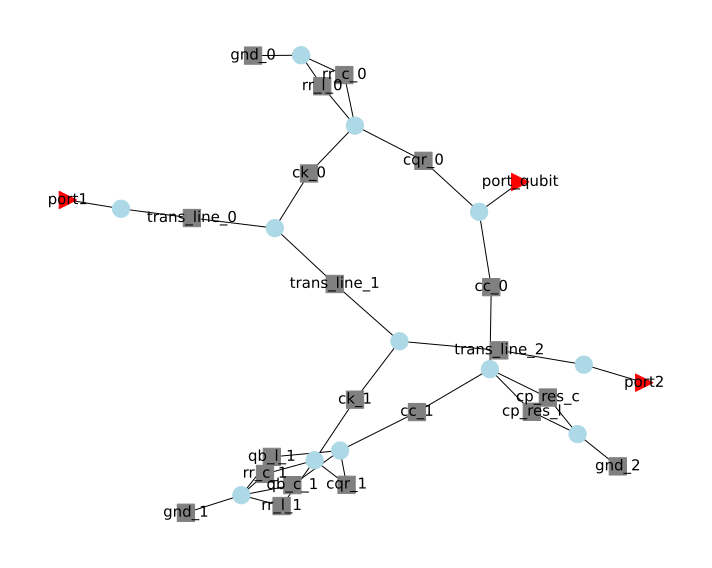

In [ ]:
fl_traits = pd.read_csv("two_clockmons_00.csv").values[0][1:]
transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)/2*1e6]
options = {
    "qubit_c": np.array([c_sigma]*2) - np.array([c_r1, c_r2]) - np.array([c_c1, c_c2]) ,
    "qubit_l": np.array([Lj1, Lj2]),
    "readout_resonator_c": c_rr - np.array([c_r1, c_r2]) - cks,
    "readout_resonator_l": l_rr,
    "substrate_thickness": 550e-6,
    "ck": cks,
    "cqr": np.array([c_r1, c_r2]),
    "cc": np.array([c_c1, c_c2]),
    "coupler_res_c": c_cr - c_c1 - c_c2,
    "coupler_res_l": l_cr,
    "feedline_traits": transmission_line_tee_points,
    "ep_r": ep_r,
    "a": a,
    "b": b,
    "frequency": [4.8, 4.9],
    "n_points": 1001,
    "type": "two_coupled_t1"
}
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

In [ ]:
Y_real_s1 = ntw.y[0, 0, 0].real
T1_s1_readout_purcell_limit = c_sigma/Y_real_s1
T1_s1_readout_purcell_limit

0.0005011871374168639

# scikit-rf check for loaded waveguide length correction

In [ ]:
# freq = rf.Frequency(start=7.35, stop=7.45, unit='GHz', npoints=1001)
# capacitor = rf.DefinedGammaZ0(freq, z0=50).capacitor
# inductor = rf.DefinedGammaZ0(freq, z0=50).inductor
# cpw = CPW(frequency = freq, w = 10e-6, s = 6e-6, ep_r = ep_r)
# port1 = rf.Circuit.Port(freq, 'port1', z0=50) # Launcher 1
# port2 = rf.Circuit.Port(freq, 'port2', z0=50) # Launcher 2
# port3 = rf.Circuit.Port(freq, 'port3', z0=50) # Launcher 2
# gnd1 = rf.Circuit.Ground(freq, name='gnd1')
# gnd2 = rf.Circuit.Ground(freq, name='gnd2')
# gnd3 = rf.Circuit.Ground(freq, name='gnd3')
# gnd4 = rf.Circuit.Ground(freq, name='gnd4')


# tl_in = cpw.line(d = 5/1e6, unit='m', name='trans_line_in')
# tl_out = cpw.line(d = 5/1e6, unit='m', name='trans_line_out')
# cap = capacitor(cks[0], name='ck')
# ground_cap = capacitor(ck_to_ground(cks[0]), name = 'ckg')
# ground_ind_cap = inductor(digit_cap_inductance, name = "lkg")

# cqr = capacitor(c_r1, name='cqr')
# ground_cqr = capacitor(cr1_to_ground((c_r1, c_c1)), name = 'cqrg')
# ground_lqr = inductor(tee_cap_inductance, name = "lqr")

# qubit_c = capacitor(90e-15, name='cs')
# qubit_l = inductor(14e-9, name = 'lj')

# wg1_len, wg2_len, wg3_len = (306.8 + 11)/1e6, (958.416 + 31)/1e6, (366.473 + 11)/1e6
# wg1 = cpw.line(d = wg1_len, unit='m', name='wg1') # corrected to take into account the tee
# wg2 = cpw.line(d = wg2_len, unit='m', name='wg2')
# wg3 = cpw.line(d = wg3_len, unit='m', name='wg3')

# meander_length = rr_waveguide_lengths[0]- wg1_len - wg2_len - wg3_len
# meander = cpw.line(d = meander_length, unit='m', name='meander')

# cnx = [ [(port1, 0), (tl_in, 0)],
#     [(tl_in, 1), (tl_out, 0), (cap, 0)],
#     [(tl_out, 1), (port2, 0)],
#     [(ground_ind_cap, 0), (cap, 1), (ground_cap, 0)],
#     [(ground_ind_cap, 1), (wg1, 0)],
#     [(ground_cap, 1), (gnd3, 0)],
#     [(wg1, 1), (wg2, 0), (wg3, 0)],
#     [(wg3, 1), (meander, 0)],
#     [(meander, 1), (gnd1, 0)],
#     [(ground_lqr, 0), (cqr, 0), (ground_cqr, 0)],
#     [(ground_lqr, 1), (wg2, 1)],
#     [(ground_cqr, 1), (gnd4, 0)],
#     [(cqr, 1), (qubit_c, 0), (qubit_l, 0)],
#     [(qubit_c, 1), (qubit_l, 1), (gnd2, 0)]
# ]

# cir = rf.Circuit(cnx)

# cir.plot_graph(network_labels=True, network_fontsize=15,
#                port_labels=True, port_fontsize=15,
#                edge_fontsize=10)

# # Get the resulting Network from the 'network' parameter:
# ntw = cir.network
# print(ntw)